<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,precision_score, recall_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_curve

## Исследование задачи

In [2]:
df=pd.read_csv('./Churn.csv')
df.info()
df.head ()
#first info about the files

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


В целом данные полные, пропуски есть только в столбце Tenure. Категориальные данные уже преобразованы в систему 1/0. Признаки CustomerId Surname можно исключить.

In [3]:
#удалим  признаки, которые не влияют на отток клиентов
df.drop(columns=['CustomerId','Surname', 'RowNumber'],axis=1,inplace=True)


In [4]:
# Применим one hot encoding к датафрейму, избежав "ловушку фиктивных признаков"
df_ohe=pd.get_dummies(df, drop_first=True)
df_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [5]:
#проанализируем пропуски
display(df_ohe['Tenure'].value_counts())
display(df_ohe['Age'].value_counts())

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

37    478
38    477
35    474
36    456
34    447
     ... 
92      2
82      1
88      1
85      1
83      1
Name: Age, Length: 70, dtype: int64

Пропусков только 10% и сложно понять есть ли какая либо связь с другими категортиями данных. Пока предлагаю заполнить случайными значениями.

Text(0.5, 1.0, 'Tenure')

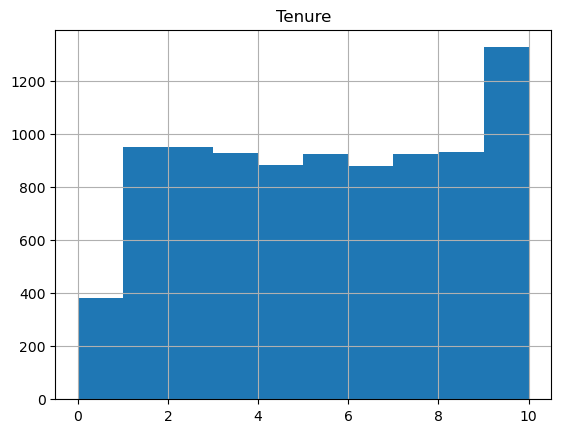

In [6]:
#построим гистограмму
df_ohe['Tenure'].hist()
plt.title('Tenure')

In [7]:
#Заполняем пропуски
values = (np.random.randint(0,10,size=df['Tenure'].isna().sum()))
df_ohe.loc[df_ohe['Tenure'].isna(),'Tenure']=values

Text(0.5, 1.0, 'Tenure')

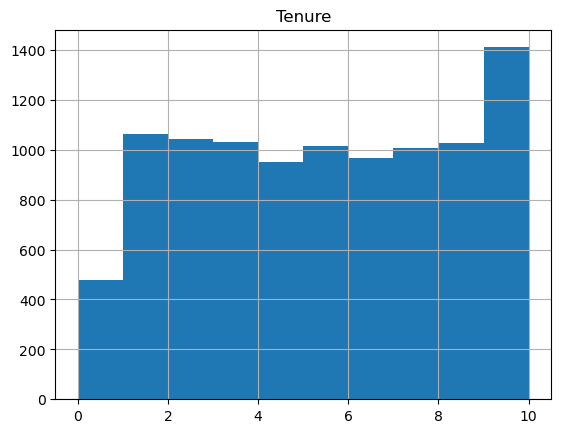

In [8]:
#Проверим распределение после заполнения пропусков
df_ohe['Tenure'].hist()
plt.title('Tenure')

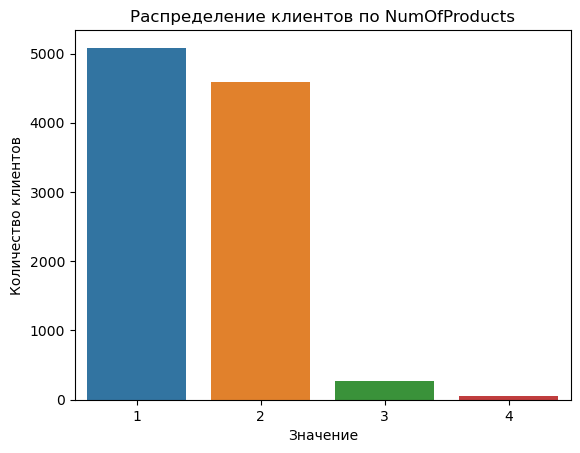

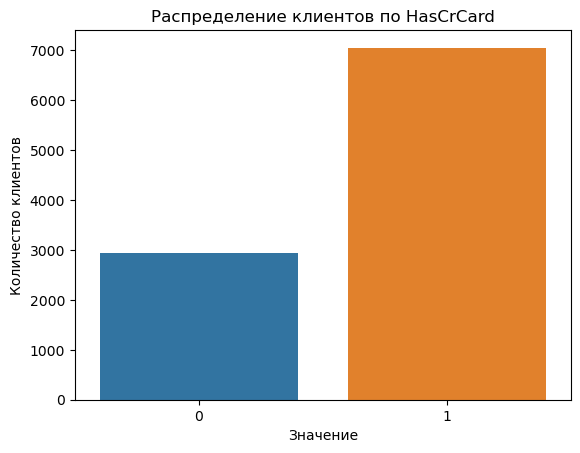

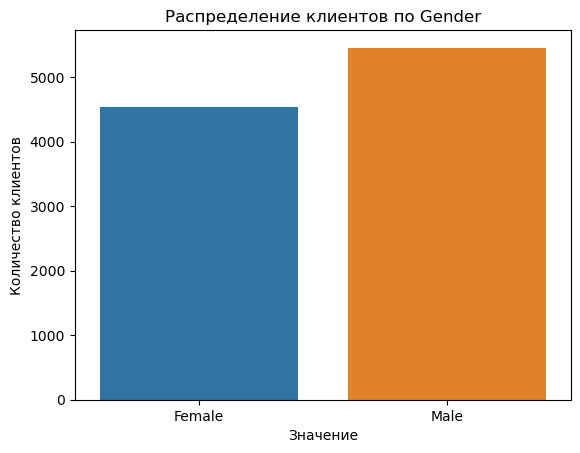

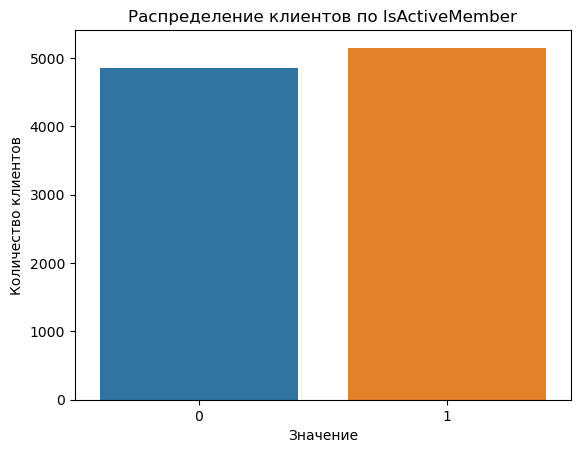

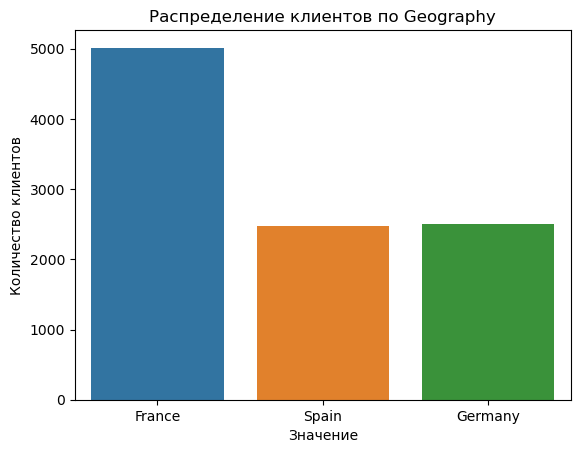

In [9]:
#проверим визуально возможный дисбаланс в категориальных признаках:
for col in df[['NumOfProducts', 'HasCrCard', 'Gender', 'IsActiveMember', 'Geography']].columns:
    ax = sns.countplot(x = col, data = df)
    plt.title('Распределение клиентов по ' + col)
    plt.ylabel('Количество клиентов')
    plt.xlabel('Значение')
    plt.show()

/var/folders/l3/ptk1k6y52tj8vrvkxh61kwch0000gn/T/ipykernel_10474/4128926936.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


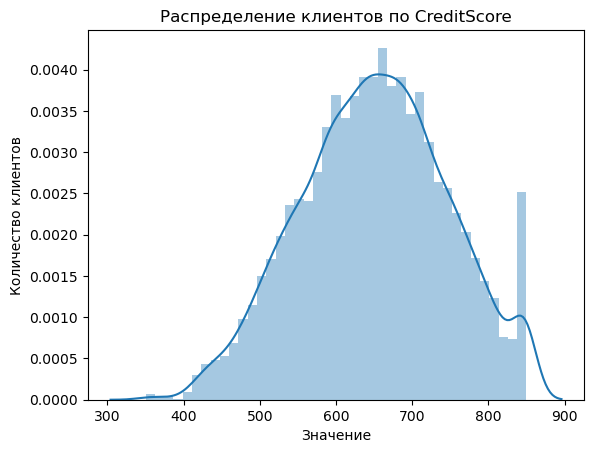

/var/folders/l3/ptk1k6y52tj8vrvkxh61kwch0000gn/T/ipykernel_10474/4128926936.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


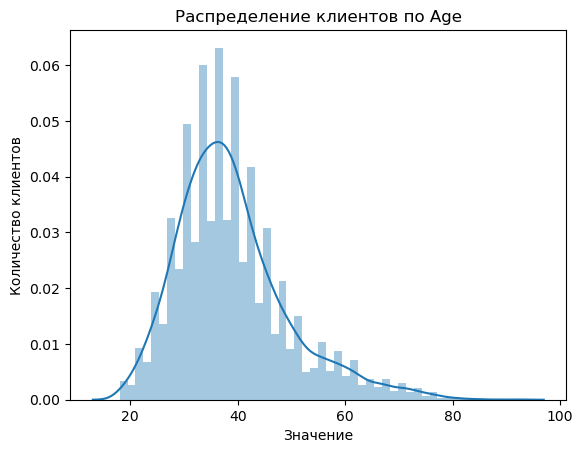

/var/folders/l3/ptk1k6y52tj8vrvkxh61kwch0000gn/T/ipykernel_10474/4128926936.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


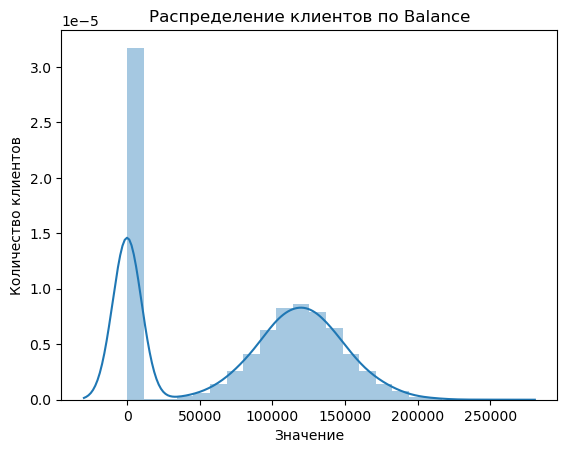

/var/folders/l3/ptk1k6y52tj8vrvkxh61kwch0000gn/T/ipykernel_10474/4128926936.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


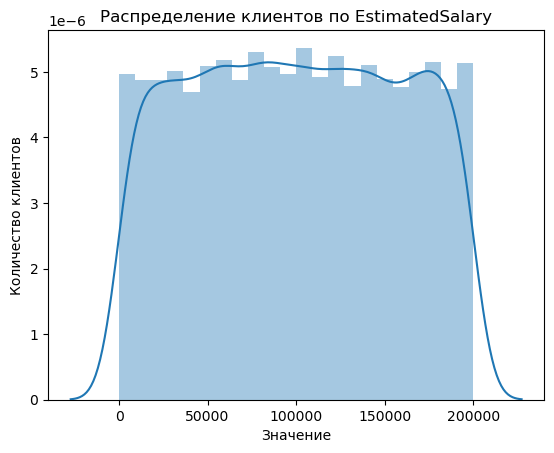

/var/folders/l3/ptk1k6y52tj8vrvkxh61kwch0000gn/T/ipykernel_10474/4128926936.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


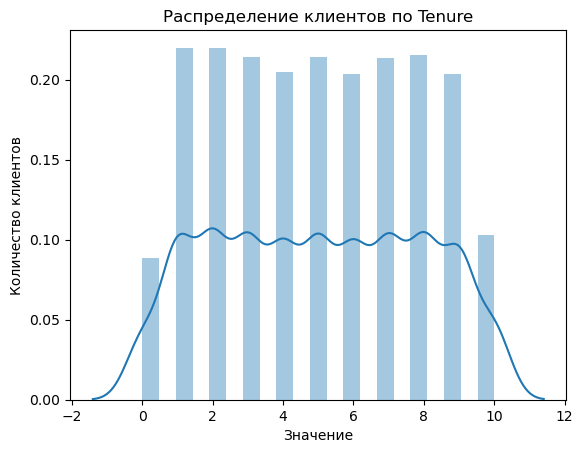

In [10]:
# Визуализируем непрерывные признаки
for col in df[['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure']].columns:
    sns.distplot(df[col])
    plt.title('Распределение клиентов по ' + col)
    plt.ylabel('Количество клиентов')
    plt.xlabel('Значение')
    plt.show()


В выборке:
**CreditScore**´- нормальное распределение со сдвигом в право
**Geography** - большая часть клиентов из Франции
**Gender** - почти равные значения
**Age** - нормальное распределение
**Tenure** - почти равномерное распределение
**Balance** - нормальное распределение с выбросом
**NumOfProducts** - в основном не больше 2х продуктов
**HasCrCard** - на 50% больше держателей карт
**IsActiveMember** - равные значения
**EstimatedSalary** - распределена почти равномерно
**Exited** - отрицательных значений больше


In [11]:
# Разделим тестовую, обучающую , валидационную выборки:
#Разобьем выборку по принципу 70/15/15.

target = df_ohe['Exited']
features  = df_ohe.drop('Exited',axis  = 1)

features_train, features_set, target_train, target_set  = train_test_split(
    features, target, test_size=0.3, random_state=12345)

features_test, features_valid, target_test, target_valid,  = train_test_split(
    features_set, target_set, test_size= 0.5,  random_state=12345)

print('Размер тренериующей выборки', target_train.shape[0])
print('Размер валидационной выборки', target_valid.shape[0])
print('Размер тестовой выборки', target_test.shape[0])



#target = df_ohe['Exited']
#features = df_ohe.drop('Exited', axis=1)
#features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

Размер тренериующей выборки 7000
Размер валидационной выборки 1500
Размер тестовой выборки 1500


In [12]:
# Нормируем числовые данные, используя StandardScaler

numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure','NumOfProducts']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric]= scaler.transform(features_test[numeric])

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(7000, 11)
(1500, 11)
(1500, 11)


Построим модели без проверки на дисбаланс признаков

In [13]:
#модель логистической регрессии
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))
#print("ROC_auc:", roc_auc_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one = probabilities_valid[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target_valid, probabilities_one))


F1: 0.28037383177570097
Площадь ROC-кривой: 0.7396685769192995


In [14]:
# модель случайного леса  - подбор параметров

best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 60, 10):
    for depth in range (1, 101):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth )
        
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid) 
        
        result = f1_score(target_valid, predictions_valid)
        if result > best_result:
            best_model = model
            best_est = est
            best_depth = depth
            best_result = result
print('Лучшая точность', best_result,"Количество деревьев:", best_est, "Оптимальная глубина:", best_depth)

Лучшая точность 0.5629921259842521 Количество деревьев: 50 Оптимальная глубина: 25


In [15]:
# модель случайного леса
model = RandomForestClassifier(random_state=12345, n_estimators=40, max_depth = 20)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one = probabilities_valid[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target_valid, probabilities_one))

F1: 0.5236220472440944
Площадь ROC-кривой: 0.8414565521488351


In [39]:
#проверить модель случайного леса со сбалансированной выборкой
model = RandomForestClassifier(n_estimators = 40, random_state = 12345, max_depth = 20, class_weight = 'balanced' )
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))
robabilities_valid = model.predict_proba(features_valid)
probabilities_one = probabilities_valid[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target_valid, probabilities_one))

F1: 0.5101214574898786
Площадь ROC-кривой: 0.5164609981976912


In [40]:
#new hyperparametres
model = RandomForestClassifier(random_state=12345, n_estimators=50, max_depth = 25)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one = probabilities_valid[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target_valid, probabilities_one))

F1: 0.5629921259842521
Площадь ROC-кривой: 0.8467413779831661


In [16]:
%%time

model = RandomForestClassifier(n_estimators=100, random_state=12345)
model.fit(features_train, target_train)

CPU times: user 608 ms, sys: 3.47 ms, total: 611 ms
Wall time: 610 ms


RandomForestClassifier(random_state=12345)

In [17]:
# модель решающего дерева, подбор параметров


best_model = None
best_result = 0
best_depth = 0
for depth in range (1, 101):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth )
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid) 
        
    result = f1_score(target_valid, predictions_valid)
    if result > best_result:
        best_model = model
        best_est = est
        best_depth = depth
        best_result = result
print('Лучшая точность', best_result, "Оптимальная глубина:", best_depth)


Лучшая точность 0.5568181818181818 Оптимальная глубина: 5


In [18]:
# модель решающего дерева
model = DecisionTreeClassifier(random_state  = 12345, max_depth = 5)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one = probabilities_valid[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target_valid, probabilities_one))

F1: 0.5568181818181818
Площадь ROC-кривой: 0.8452323757296165


Без проверки на дисбаланс классов пока выигрывает модель случайного леса.
<br>**модель логистической регрессии**
<br>F1: 0.29213483146067415
<br>ROC_auc: 0.5786211980690115

<br>**модель случайного леса**
<br>F1: 0.5609284332688589
<br>ROC_auc: 0.847881424540597

<br>**модель решающего дерева**
<br>F1: 0.5568181818181818
<br>ROC_auc: 0.8461799813664103

## Борьба с дисбалансом

In [19]:
## Посмотрим количество объектов отрицательного и положительно класса
features[target == 0].shape, features[target == 1].shape

((7963, 11), (2037, 11))

Объектов отрицательного класса почти в 4 раза больше , чем положительного. 

1) Увеличим выборку

In [20]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [21]:
#модель логистической регрессии с увеличенной выборкой
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))
#print("ROC_auc:", roc_auc_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one = probabilities_valid[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target_valid, probabilities_one))

F1: 0.4841628959276018
Площадь ROC-кривой: 0.7438863510281655


In [22]:
# модель решающего дерева с увеличенной выборкой - подбор параметров
best_model = None
best_result = 0
best_depth = 0
for depth in range (1, 101):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth )
    model.fit(features_upsampled, target_upsampled)
    predictions_valid = model.predict(features_valid) 
        
    result = f1_score(target_valid, predictions_valid)
    if result > best_result:
        best_model = model
        best_est = est
        best_depth = depth
        best_result = result
print('Лучшая точность', best_result, "Оптимальная глубина:", best_depth)

Лучшая точность 0.5818673883626522 Оптимальная глубина: 5


In [23]:
# модель решающего дерева с увеличенной выборкой
model = DecisionTreeClassifier(random_state  = 12345, max_depth = 7)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one = probabilities_valid[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target_valid, probabilities_one))

F1: 0.5745192307692307
Площадь ROC-кривой: 0.8160928388088305


In [24]:
# модель решающего дерева, подбор параметров

#best_model = None
#best_result = 0
#best_depth = 0
#for depth in range (1, 101):
#    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight  = 'balanced' )
#    model.fit(features_train, target_train)
#    predictions_valid = model.predict(features_valid) 
#        
#    result = f1_score(target_valid, predictions_valid)
#    if result > best_result:
#        best_model = model
#        best_est = est
#        best_depth = depth
#        best_result = result
#print('Лучшая точность', best_result, "Оптимальная глубина:", best_depth)

In [25]:
# модель решающего дерева со сбалансированной выборкой

#model = DecisionTreeClassifier(random_state  = 12345, max_depth = 5, class_weight = 'balanced')
#model.fit(features_train, target_train)
#predicted_valid = model.predict(features_valid)

#print("F1:", f1_score(target_valid, predicted_valid))
#print("ROC_auc:", roc_auc_score(target_valid, predicted_valid))

In [26]:
# модель случайного леса с увеличенной выборкой - подбор параметров
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 51, 10):
    for depth in range (1, 101):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth )
        
        model.fit(features_upsampled, target_upsampled)
        predictions_valid = model.predict(features_valid) 
        
        result = f1_score(target_valid, predictions_valid)
        if result > best_result:
            best_model = model
            best_est = est
            best_depth = depth
            best_result = result
print('Лучшая точность', best_result,"Количество деревьев:", best_est, "Оптимальная глубина:", best_depth)

Лучшая точность 0.6248331108144193 Количество деревьев: 40 Оптимальная глубина: 8


In [27]:
# модель случайного леса с увеличенной выборкой 
model = RandomForestClassifier(n_estimators  = 30, random_state  = 12345, max_depth = 7)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one = probabilities_valid[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target_valid, probabilities_one))

F1: 0.6149870801033592
Площадь ROC-кривой: 0.8508781941874879


In [28]:
# модель случайного леса со сбалансированной выборкой 
#model = RandomForestClassifier(n_estimators  = 60, random_state  = 12345, max_depth = 13, class_weight = 'balanced' )
#model.fit(features_train, target_train)
#predicted_valid = model.predict(features_valid)

#print("F1:", f1_score(target_valid, predicted_valid))
#print("ROC_auc:", roc_auc_score(target_valid, predicted_valid)) 

Лучший результат показывает модель случайного леса с увеличенной выборкой .

модель случайного леса с увеличенной выборкой
<br>F1: 0.6225165562913907
<br>ROC_auc: 00.8516187599372511

модель решающего дерева с увеличенной выборкой
<br>F1: 0.5825242718446602
<br>Площадь ROC-кривой: 0.8142507146857638

модель логистической регрессии с увеличенной выборкой
<br>F1: 0.48574686431014824
<br>Площадь ROC-кривой: 0.7445101250467829

1) Уменьшим выборку

In [29]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [30]:
#модель логистической регрессии с уменьшенной выборкой
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))
#print("ROC_auc:", roc_auc_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one = probabilities_valid[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target_valid, probabilities_one))

F1: 0.48
Площадь ROC-кривой: 0.7440429581222012


In [31]:
# модель решающего дерева с уменьшенной выборкой - подбор параметров
best_model = None
best_result = 0
best_depth = 0
for depth in range (1, 101):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth )
    model.fit(features_downsampled, target_downsampled)
    predictions_valid = model.predict(features_valid) 
        
    result = f1_score(target_valid, predictions_valid)
    if result > best_result:
        best_model = model
        best_est = est
        best_depth = depth
        best_result = result
print('Лучшая точность', best_result, "Оптимальная глубина:", best_depth)

Лучшая точность 0.584382871536524 Оптимальная глубина: 6


In [32]:
# модель решающего дерева с уменьшенной выборкой
model = DecisionTreeClassifier(random_state  = 12345, max_depth = 6)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one = probabilities_valid[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target_valid, probabilities_one))

F1: 0.584382871536524
Площадь ROC-кривой: 0.8349520490312922


In [33]:
# модель случайного леса с уменьшенной выборкой - подбор параметров
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 51, 10):
    for depth in range (1, 101):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth )
        
        model.fit(features_downsampled, target_downsampled)
        predictions_valid = model.predict(features_valid) 
        
        result = f1_score(target_valid, predictions_valid)
        if result > best_result:
            best_model = model
            best_est = est
            best_depth = depth
            best_result = result
print('Лучшая точность', best_result,"Количество деревьев:", best_est, "Оптимальная глубина:", best_depth)

Лучшая точность 0.6198243412797994 Количество деревьев: 50 Оптимальная глубина: 8


In [34]:
# модель случайного леса с уменьшенной выборкой 
model = RandomForestClassifier(n_estimators  = 40, random_state  = 12345, max_depth = 8)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one = probabilities_valid[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target_valid, probabilities_one))

F1: 0.6081424936386769
Площадь ROC-кривой: 0.8546407459806391


**Лучший результат показывает случайного леса с уменьшенной выборкой .**

модель случайного леса с уменьшенной выборкой
<br>F1: 0.6091245376078915
<br>Площадь ROC-кривой: 0.8528238382540697

модель решающего дерева с уменьшенной выборкой
<br>F1: 0.5742821473158551
<br>Площадь ROC-кривой: 0.8400510698388008

модель логистической регрессии с уменьшенной выборкой
<br>F1: 0.48220436280137774
<br>Площадь ROC-кривой: 0.7450569226971456

`**Уменьшение выборки приводит к ухудшению метрик.**

модель случайного леса с уменьшенной выборкой
<br>F1: 0.6091245376078915
<br>Площадь ROC-кривой: 0.8528238382540697

модель случайного леса с увеличенной выборкой
<br>F1: 0.6225165562913907
<br>ROC_auc: 00.8516187599372511

`**Для тестирования выберем модель случайного леса с увеличенной выборкой, так как у данной модели лучшие метрики.**


модель случайного леса с увеличенной выборкой
<br>F1: 0.6225165562913907
<br>ROC_auc: 00.8516187599372511
    
<br>Количество деревьев: 30 Оптимальная глубина: 7

## Тестирование модели

In [35]:
target_pred_constant = pd.Series([1]*len(target))

print("F1:", f1_score(target, target_pred_constant))
print("ROC_auc:", roc_auc_score(target, target_pred_constant))
print("accuracy:", accuracy_score(target, target_pred_constant))

F1: 0.3384564260197724
ROC_auc: 0.5
accuracy: 0.2037


Константная модель которая всегда прогнозирует 1 явно уступает в метриках обученным моделям

In [36]:

# проверим результаты на тестовой выборке
model = RandomForestClassifier(n_estimators  = 30, random_state  = 12345, max_depth = 7)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_test)

print("F1:", f1_score(target_test, predicted_valid))

probabilities_valid = model.predict_proba(features_test)
probabilities_one = probabilities_valid[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target_test, probabilities_one))

F1: 0.6170212765957447
Площадь ROC-кривой: 0.856300733649874


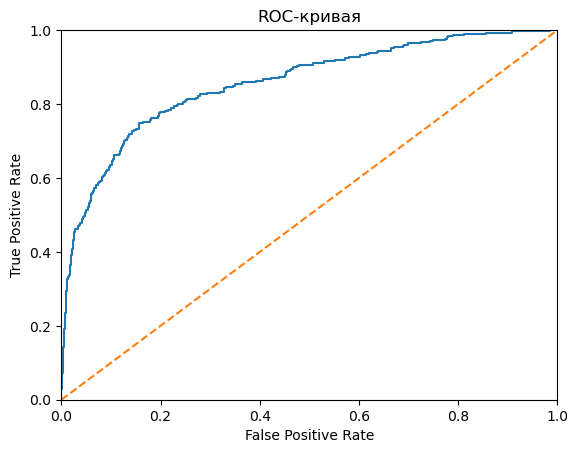

In [37]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

In [38]:
precision = precision_score(target_test, predicted_valid) 
recall = recall_score(target_test, predicted_valid)

print("Полнота:", recall)
print("Точность:", precision)

Полнота: 0.755700325732899
Точность: 0.5213483146067416



**Вывод**
Лучший результат показывает модель случайного леса увеличенной выборкой .


F1: 0.6219839142091153
Площадь ROC-кривой: 0.8582447556457184

Мера F1 показывает, что прогноз класса 1 удался. ROC кривая: меткрика лучше,чем у случайной модели, но до идеальной можно продолжить работать с данными. Recall = 0.75, что значит, что 75% из ушедших клиентов мы сможем определить правильно

<div style="border:solid Chocolate 2px; padding: 40px">

**Комментарий ко второй проверке**

Спасибо за отличную доработку. Критичных комментариев нет. 

Желаю удачи в дальнейшей учебе!

</div>


## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: задача исследована
    - [ ]  Исследован баланс классов
    - [ ]  Изучены модели без учёта дисбаланса
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 3: учтён дисбаланс
    - [ ]  Применено несколько способов борьбы с дисбалансом
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 4: проведено тестирование
- [ ]  Удалось достичь *F1*-меры не менее 0.59
- [ ]  Исследована метрика *AUC-ROC*